# 1. Preprocessing
## Import data

In [4]:
! pip install scikeras
! pip install pandas
! pip install nltk
! pip install scikit-learn


pyenv: pip: command not found

The `pip' command exists in these Python versions:
  3.10.13

Note: See 'pyenv help global' for tips on allowing both
      python2 and python3 to be found.
pyenv: pip: command not found

The `pip' command exists in these Python versions:
  3.10.13

Note: See 'pyenv help global' for tips on allowing both
      python2 and python3 to be found.
pyenv: pip: command not found

The `pip' command exists in these Python versions:
  3.10.13

Note: See 'pyenv help global' for tips on allowing both
      python2 and python3 to be found.
pyenv: pip: command not found

The `pip' command exists in these Python versions:
  3.10.13

Note: See 'pyenv help global' for tips on allowing both
      python2 and python3 to be found.


In [7]:
import pandas as pd
df = pd.read_csv('training.300000.processed.noemoticon.csv', encoding='ISO-8859-1')

## Text clean

In [8]:
import nltk
nltk.download("stopwords")
nltk.download("punkt")
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/liuyifan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/liuyifan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/liuyifan/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [3]:
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))


def clean_text(text):
    # transfer to lower characters
    text = text.lower()
    
    # eliminate url link
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # eliminate special character
    text = re.sub(r'@\w+|#\w+', '', text)
    
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # eliminate stop word
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    
   
    return ' '.join(tokens)

# apply clean function to data frame
df['cleaned_text'] = df['text'].apply(clean_text)

df[['text', 'cleaned_text']].head()

,text,cleaned_text
0,@chrishasboobs AHHH I HOPE YOUR OK!!!,ahhh hope ok
1,"@misstoriblack cool , i have no tweet apps fo...",cool tweet apps razr
2,@TiannaChaos i know just family drama. its la...,know family drama lamehey next time u hang kim...
3,School email won't open and I have geography ...,school email wont open geography stuff revise ...
4,upper airways problem,upper airways problem


## Divide dataset into two parts, trainset and testset

In [4]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Transfer original labels to 0-1 label
y = df['sentiment'].values  
y = (y == 4).astype(int) 
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_text'], y, test_size=0.2, random_state=42)


## Tokenization, Padding

In [5]:
# Define tokenizer
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

# Transfer to sequences
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# Padding sequence to a constant length
X_train = pad_sequences(X_train, maxlen=50)
X_test = pad_sequences(X_test, maxlen=50)


# 2. Deep learning

## CNN
Model implement

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Embedding, Dropout, Flatten, Input

# from previous block, which maximum length of sequence is 50
sequence_length = 50

# define cnn
model_1 = Sequential()

# add input layer
model_1.add(Input(shape=(sequence_length,)))

# add embedding layer, map word id to a vector
model_1.add(Embedding(input_dim=10000, output_dim=50))

# convolutional layer
model_1.add(Conv1D(filters=128, kernel_size=5, activation='relu'))

# pool layer
model_1.add(MaxPooling1D(pool_size=2))

# fc1
model_1.add(Flatten())

# Dropout layer
model_1.add(Dropout(0.5))

# fc2
model_1.add(Dense(64, activation='relu'))

# output layer
model_1.add(Dense(1, activation='sigmoid'))

model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# show model structure
model_1.summary()

model_1.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.2)
loss, accuracy = model_1.evaluate(X_test, y_test)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 50, 50)         │       500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 46, 128)        │        32,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 23, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2944)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2944)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       188,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 720,673 (2.75 MB)

 Trainable params: 720,673 (2.75 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.7060 - loss: 0.5474 - val_accuracy: 0.7718 - val_loss: 0.4763
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.7958 - loss: 0.4403 - val_accuracy: 0.7738 - val_loss: 0.4700
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.8185 - loss: 0.3988 - val_accuracy: 0.7690 - val_loss: 0.4946
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.8436 - loss: 0.3524 - val_accuracy: 0.7617 - val_loss: 0.5284
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.8652 - loss: 0.3078 - val_accuracy: 0.7559 - val_loss: 0.5800
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.8807 - loss: 0.2745 - val_accuracy: 0.7498 - val_loss: 0.6678
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.8919 - loss: 0.2496 - val_accuracy: 0.7477 - val_loss: 0.7484
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.9004 -

Fine tune

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Embedding, Dropout, Flatten, Input
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
import json


# Define cnn model structure
def create_model(optimizer='adam', filters=64, kernel_size=5, dropout_rate=0.5):
    sequence_length = 50  
    model = Sequential()
    model.add(Input(shape=(sequence_length,)))
    model.add(Embedding(input_dim=10000, output_dim=50))
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model
# Wrape Keras model for sklearn
model_1_f = KerasClassifier(build_fn=create_model, epochs=10, batch_size=128, verbose=0)

# Search list
param_dist = {
    'model__optimizer': ['adam', 'rmsprop'],
    'model__filters': [32, 64, 128],
    'model__kernel_size': [3, 5],
    'model__dropout_rate': [0.2, 0.3],
    'epochs': [5, 10, 15],
    'batch_size': [32, 64]
}

random_search = RandomizedSearchCV(estimator=model_1_f, param_distributions=param_dist, n_iter=10, cv=3)
random_search.fit(X_train,y_train)
# save best paramaters combination
best_params = random_search.best_params_
with open('best_paramscnn.json', 'w') as f:
    json.dump(best_params, f)
#    
model_1_best=random_search.best_estimator_.model_
model_1_best.save("bestcnn.h5")


/home/liu/miniconda3/envs/tensorflow/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/liu/miniconda3/envs/tensorflow/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/liu/miniconda3/envs/tensorflow/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/liu/miniconda3/envs/tensorflow/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will 

RandomizedSearchCV(cv=3,
                   estimator=KerasClassifier(batch_size=128, build_fn=<function create_model at 0x7fce7c740e00>, epochs=10, verbose=0),
                   param_distributions={'batch_size': [32, 64],
                                        'epochs': [5, 10, 15],
                                        'model__dropout_rate': [0.2, 0.3],
                                        'model__filters': [32, 64, 128],
                                        'model__kernel_size': [3, 5],
                                        'model__optimizer': ['adam',
                                                             'rmsprop']})

In [ ]:
import json
from sklearn.metrics import accuracy_score

# get best parameters combination
best_params = random_search.best_params_

# save each parameters in a json file
with open('best_paramscnn.json', 'w') as f:
    json.dump(best_params, f)





## LSTM
model implement

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, Input
from tensorflow.keras.optimizers import Adam
def create_lstm_model(optimizer='adam',output_dim=50 ,units=64,dropout_rate=0.5):
    model=Sequential()
    sequence_length=50
    model.add(Input(shape=(sequence_length,)))
    model.add(Embedding(input_dim=10000, output_dim=output_dim))
    model.add(LSTM(units=units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

model_2=create_lstm_model()
model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_2.summary()
model_2.fit(X_train,y_train,epochs=10, batch_size=128, validation_split=0.2)
loss, accuracy=model_2.evaluate(X_test,y_test)
    
    

2024-10-09 18:47:00.115403: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2024-10-09 18:47:00.115444: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-10-09 18:47:00.115451: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-10-09 18:47:00.115471: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-09 18:47:00.115487: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 50, 50)         │       500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 533,665 (2.04 MB)

 Trainable params: 533,665 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


2024-10-09 18:47:00.666863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - accuracy: 0.7189 - loss: 0.5416 - val_accuracy: 0.7716 - val_loss: 0.4801
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 26s 17ms/step - accuracy: 0.7902 - loss: 0.4475 - val_accuracy: 0.7725 - val_loss: 0.4726
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 26s 18ms/step - accuracy: 0.8021 - loss: 0.4236 - val_accuracy: 0.7729 - val_loss: 0.4780
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 26s 17ms/step - accuracy: 0.8125 - loss: 0.4034 - val_accuracy: 0.7688 - val_loss: 0.4893
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 26s 17ms/step - accuracy: 0.8230 - loss: 0.3846 - val_accuracy: 0.7674 - val_loss: 0.5079
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 26s 18ms/step - accuracy: 0.8354 - loss: 0.3608 - val_accuracy: 0.7660 - val_loss: 0.5312
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 26s 17ms/step - accuracy: 0.8457 - loss: 0.3388 - val_accuracy: 0.7597 - val_loss: 0.5736
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 26s 17ms/step - accuracy: 0.8561 - loss: 0.32

Fine Tune

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, Input
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.optimizers import Adam
import json

def create_lstm_model(optimizer='adam',output_dim=50 ,units=64,dropout_rate=0.5):
    model=Sequential()
    sequence_length=50
    model.add(Input(shape=(sequence_length,)))
    model.add(Embedding(input_dim=10000, output_dim=output_dim))
    model.add(LSTM(units=units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model
# Wrape Keras model for sklearn
model_2_f = KerasClassifier(build_fn=create_lstm_model, epochs=10, batch_size=128, verbose=0)
# Search list
param_dist = {
    'model__optimizer': ['adam', 'rmsprop'],
    'model__output_dim': [50, 100, 150,200],
    'model__units': [64, 128],
    'model__dropout_rate': [0.2, 0.3,0.5],
    'epochs': [5, 10, 15],
    'batch_size': [32, 64]
}
random_search = RandomizedSearchCV(estimator=model_2_f, param_distributions=param_dist, n_iter=10, cv=3, n_jobs=2)
random_search.fit(X_train,y_train)

# save best paramaters combination
best_params = random_search.best_params_
with open('best_paramlstm.json', 'w') as f:
    json.dump(best_params, f)
#    
model_2_best=random_search.best_estimator_.model_
model_2_best.save("bestlstm.h5")

/Users/liuyifan/.pyenv/versions/3.10.13/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/liuyifan/.pyenv/versions/3.10.13/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
2024-10-09 19:22:59.306833: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2024-10-09 19:22:59.306833: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2024-10-09 19:22:59.306856: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-10-09 19:22:59.306856: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-10-09 19:22:59.306862: I metal_plugin/src/device/meta

## Transformer

Implement

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, Dropout, LayerNormalization, Embedding
import numpy as np

# Define attention
class MultiHeadAttention(Layer):
    def __init__(self, num_heads, d_model):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        self.depth = d_model // num_heads
        
        self.wq = Dense(d_model)
        self.wk = Dense(d_model)
        self.wv = Dense(d_model)
        
        self.dense = Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        # Scaled dot-product attention
        scaled_attention_logits = tf.matmul(q, k, transpose_b=True)
        scaled_attention_logits /= tf.math.sqrt(tf.cast(self.depth, tf.float32))

        if mask is not None:
            scaled_attention_logits += (mask * -1e9)

        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        output = tf.matmul(attention_weights, v)

        output = tf.transpose(output, perm=[0, 2, 1, 3])
        output = tf.reshape(output, (batch_size, -1, self.d_model))
        return self.dense(output)

# feedforward network
class FeedForward(Layer):
    def __init__(self, d_model, d_ff):
        super(FeedForward, self).__init__()
        self.linear1 = Dense(d_ff, activation='relu')
        self.linear2 = Dense(d_model)

    def call(self, x):
        return self.linear2(self.linear1(x))

# Add & Norm layer
class AddNormalization(Layer):
    def __init__(self):
        super(AddNormalization, self).__init__()
        self.layer_norm = LayerNormalization(epsilon=1e-6)

    def call(self, x, sublayer_output):
        return self.layer_norm(x + sublayer_output)

# encoder
class EncoderLayer(Layer):
    def __init__(self, num_heads, d_model, d_ff, rate=0.1):
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(num_heads, d_model)
        self.ffn = FeedForward(d_model, d_ff)
        self.add_norm1 = AddNormalization()
        self.add_norm2 = AddNormalization()
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, x, training, mask):
        attn_output = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.add_norm1(x, attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.add_norm2(out1, ffn_output)
class Encoder(Layer):
    def __init__(self, num_layers, num_heads, d_model, d_ff, input_vocab_size, maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.embedding = Embedding(input_vocab_size, d_model)
        self.pos_encoding = self.positional_encoding(maximum_position_encoding, self.d_model)

        self.enc_layers = [EncoderLayer(num_heads, d_model, d_ff, rate) for _ in range(num_layers)]
        self.dropout = Dropout(rate)

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(np.arange(position)[:, np.newaxis], np.arange(d_model)[np.newaxis, :], d_model)
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])  
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])  
        pos_encoding = angle_rads[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)

    def get_angles(self, pos, i, d_model):
        return pos / np.power(10000, (2 * (i // 2)) / np.float32(d_model))

    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        return self.dropout(x, training=training)

class TransformerModel(tf.keras.Model):
    def __init__(self, num_layers, num_heads, d_model, d_ff, input_vocab_size, maximum_position_encoding):
        super(TransformerModel, self).__init__()
        self.encoder = Encoder(num_layers, num_heads, d_model, d_ff, input_vocab_size, maximum_position_encoding)
        self.pooling = tf.keras.layers.GlobalAveragePooling1D()  
        self.dense = Dense(2, activation='softmax')  

    def create_padding_mask(self, seq):
        mask = tf.cast(tf.equal(seq, 0), tf.float32)  
        return mask[:, tf.newaxis, tf.newaxis, :]  

    def call(self, x, training=False):
        mask = self.create_padding_mask(x)  
        x = self.encoder(x, training=training, mask=mask)  
        x = self.pooling(x)  
        return self.dense(x)  


In [10]:
num_layers = 2
num_heads = 4
d_model = 128
d_ff = 512
input_vocab_size = 10000
maximum_position_encoding = 50

model_3 = TransformerModel(num_layers, num_heads, d_model, d_ff, input_vocab_size, maximum_position_encoding)

# Compile model
model_3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_3.summary()
model_3.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.1)


Model: "transformer_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Encoder)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


/Users/liuyifan/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'encoder', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


3375/3375 ━━━━━━━━━━━━━━━━━━━━ 40s 12ms/step - accuracy: 0.6741 - loss: 0.6114 - val_accuracy: 0.7478 - val_loss: 0.5148
Epoch 2/20
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 39s 12ms/step - accuracy: 0.7640 - loss: 0.4950 - val_accuracy: 0.7682 - val_loss: 0.4983
Epoch 3/20
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 39s 12ms/step - accuracy: 0.7718 - loss: 0.4843 - val_accuracy: 0.7491 - val_loss: 0.5141
Epoch 4/20
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 39s 12ms/step - accuracy: 0.7756 - loss: 0.4796 - val_accuracy: 0.7365 - val_loss: 0.5358
Epoch 5/20
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 39s 12ms/step - accuracy: 0.7805 - loss: 0.4744 - val_accuracy: 0.7679 - val_loss: 0.5035
Epoch 6/20
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 40s 12ms/step - accuracy: 0.7792 - loss: 0.4753 - val_accuracy: 0.7595 - val_loss: 0.5062
Epoch 7/20
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - accuracy: 0.7798 - loss: 0.4734 - val_accuracy: 0.7590 - val_loss: 0.5083
Epoch 8/20
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 40s 12ms/step - accuracy: 0.7826 - loss: 0.46

In [9]:
loss, accuracy = model_3.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7675 - loss: 0.4978
Test Accuracy: 0.7657


Fine tune

In [ ]:
def create_model(num_layers=2, num_heads=4, d_model=128, d_ff=512):
    model = TransformerModel(num_layers, num_heads, d_model, d_ff, input_vocab_size, maximum_position_encoding)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

from sklearn.base import BaseEstimator, ClassifierMixin

class KerasClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, num_layers=2, num_heads=4, d_model=128, d_ff=512, epochs=10, batch_size=64):
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.d_model = d_model
        self.d_ff = d_ff
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = None

    def fit(self, X, y):
        self.model = create_model(self.num_layers, self.num_heads, self.d_model, self.d_ff)
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=0)
        return self

    def predict(self, X):
        return np.argmax(self.model.predict(X), axis=-1)

    def score(self, X, y):
        return self.model.evaluate(X, y, verbose=0)[1]  # Return accuracy

from scipy.stats import randint

param_dist = {
    'num_layers': randint(1, 4),
    'num_heads': randint(2, 8),
    'd_model': [64, 128, 256],
    'd_ff': [256, 512, 1024],
    'epochs': [10, 20],  # Add epochs to the parameter grid if needed
    'batch_size': [32, 64]  # Add batch size options
}

from sklearn.model_selection import RandomizedSearchCV

# Create a KerasClassifierWrapper instance
model = KerasClassifierWrapper()

# Set up the random search
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist,
                                   n_iter=10, cv=3, verbose=2)

# Fit the random search
random_search_result = random_search.fit(X_train, y_train)

# 3.Evaluation

Define and train model in best parameters combination

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Embedding, Dropout, Flatten, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, Input
from tensorflow.keras.optimizers import Adam


#*****************************Creating model function************************#
def create_cnnmodel(optimizer='adam', filters=64, kernel_size=5, dropout_rate=0.5):
    sequence_length = 50  
    model = Sequential()
    model.add(Input(shape=(sequence_length,)))
    model.add(Embedding(input_dim=10000, output_dim=50))
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model
def create_lstm_model(optimizer='adam',output_dim=50 ,units=64,dropout_rate=0.5):
    model=Sequential()
    sequence_length=50
    model.add(Input(shape=(sequence_length,)))
    model.add(Embedding(input_dim=10000, output_dim=output_dim))
    model.add(LSTM(units=units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model
def create_model(num_layers=2, num_heads=4, d_model=128, d_ff=512):
    model = TransformerModel(num_layers, num_heads, d_model, d_ff, input_vocab_size, maximum_position_encoding)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model
#****************************************************************************#

#*********************Get models and do the training**************************#
best_cnn_e=create_cnnmodel('adam',32,3,0.2)
history1=best_cnn_e.fit(X_train,y_train,epochs=15, batch_size=128, validation_split=0.1)
best_lstm_e=create_lstm_model(optimizer='adam',output_dim=150,units=64,dropout_rate=0.3)
history2=best_lstm_e.fit(X_train,y_train,epochs=5,batch_size=64,validation_split=0.1)
best_transf_e=create_model(1,3,128,256)
history3=best_transf_e.fit(X_train,y_train,epochs=10,batch_size=32,validation_split=0.1)
#****************************************************************************#

Epoch 1/15
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.7134 - loss: 0.5417 - val_accuracy: 0.7740 - val_loss: 0.4765
Epoch 2/15
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - accuracy: 0.7949 - loss: 0.4410 - val_accuracy: 0.7761 - val_loss: 0.4726
Epoch 3/15
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.8209 - loss: 0.3964 - val_accuracy: 0.7722 - val_loss: 0.4819
Epoch 4/15
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.8438 - loss: 0.3534 - val_accuracy: 0.7677 - val_loss: 0.5207
Epoch 5/15
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.8632 - loss: 0.3118 - val_accuracy: 0.7615 - val_loss: 0.5555
Epoch 6/15
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.8808 - loss: 0.2765 - val_accuracy: 0.7569 - val_loss: 0.6171
Epoch 7/15
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.8892 - loss: 0.2545 - val_accuracy: 0.7565 - val_loss: 0.6852
Epoch 8/15
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.8964 -

/Users/liuyifan/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'encoder_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


6750/6750 ━━━━━━━━━━━━━━━━━━━━ 64s 9ms/step - accuracy: 0.6912 - loss: 0.5772 - val_accuracy: 0.7631 - val_loss: 0.5051
Epoch 2/10
6750/6750 ━━━━━━━━━━━━━━━━━━━━ 64s 9ms/step - accuracy: 0.7636 - loss: 0.4979 - val_accuracy: 0.7707 - val_loss: 0.4988
Epoch 3/10
6750/6750 ━━━━━━━━━━━━━━━━━━━━ 63s 9ms/step - accuracy: 0.7705 - loss: 0.4882 - val_accuracy: 0.7632 - val_loss: 0.5004
Epoch 4/10
6750/6750 ━━━━━━━━━━━━━━━━━━━━ 63s 9ms/step - accuracy: 0.7755 - loss: 0.4799 - val_accuracy: 0.7680 - val_loss: 0.4987
Epoch 5/10
6750/6750 ━━━━━━━━━━━━━━━━━━━━ 60s 9ms/step - accuracy: 0.7777 - loss: 0.4765 - val_accuracy: 0.7481 - val_loss: 0.5120
Epoch 6/10
6750/6750 ━━━━━━━━━━━━━━━━━━━━ 58s 9ms/step - accuracy: 0.7833 - loss: 0.4702 - val_accuracy: 0.7590 - val_loss: 0.5094
Epoch 7/10
6750/6750 ━━━━━━━━━━━━━━━━━━━━ 58s 9ms/step - accuracy: 0.7816 - loss: 0.4738 - val_accuracy: 0.7705 - val_loss: 0.5053
Epoch 8/10
6750/6750 ━━━━━━━━━━━━━━━━━━━━ 65s 10ms/step - accuracy: 0.7798 - loss: 0.4726 - va

Evaluation

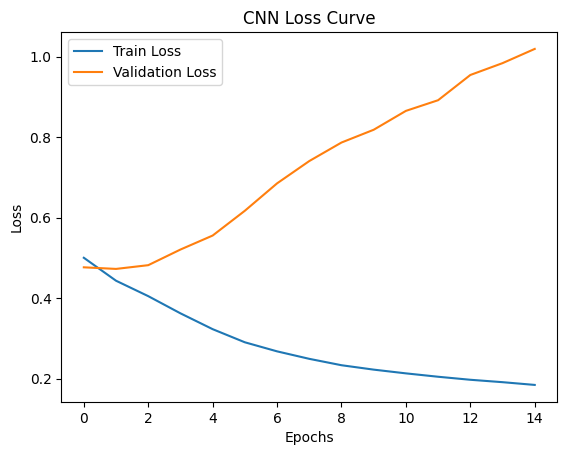

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


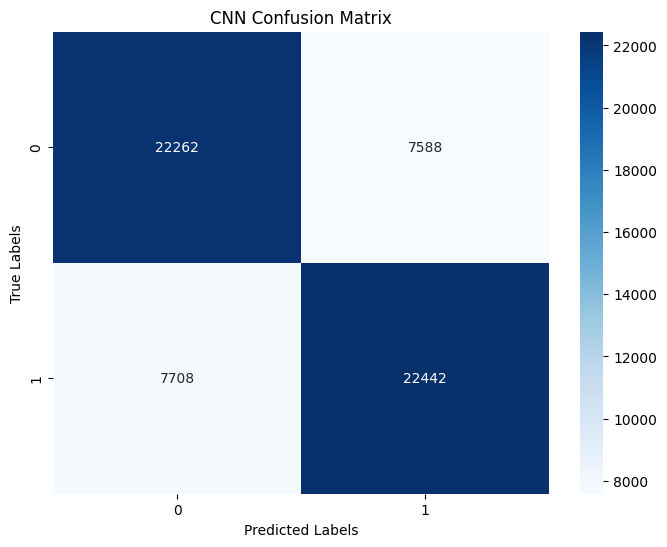

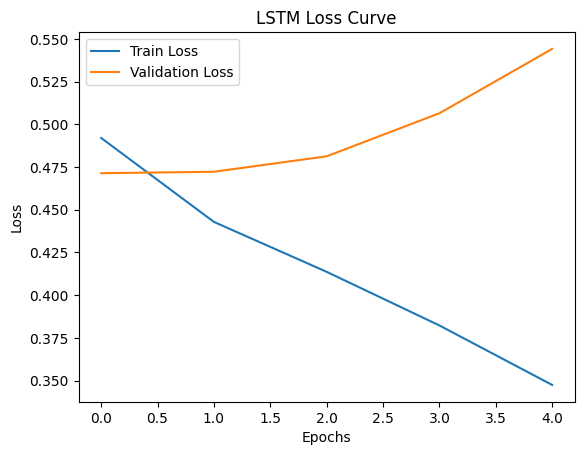

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step


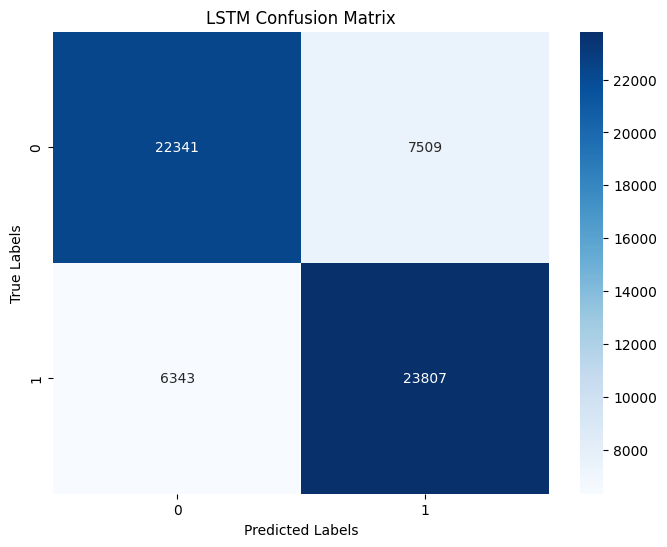

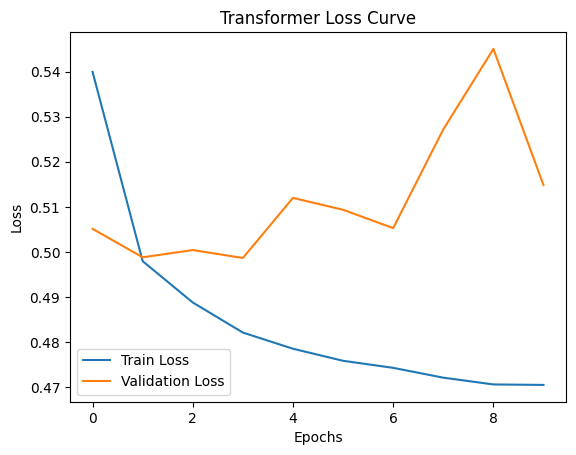

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step


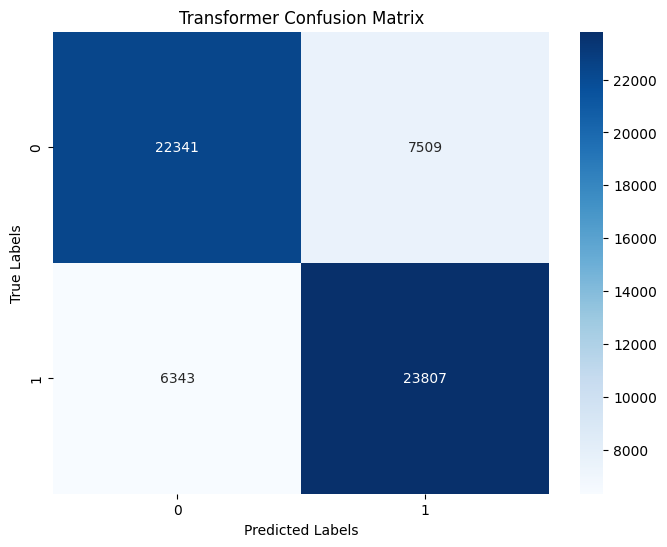

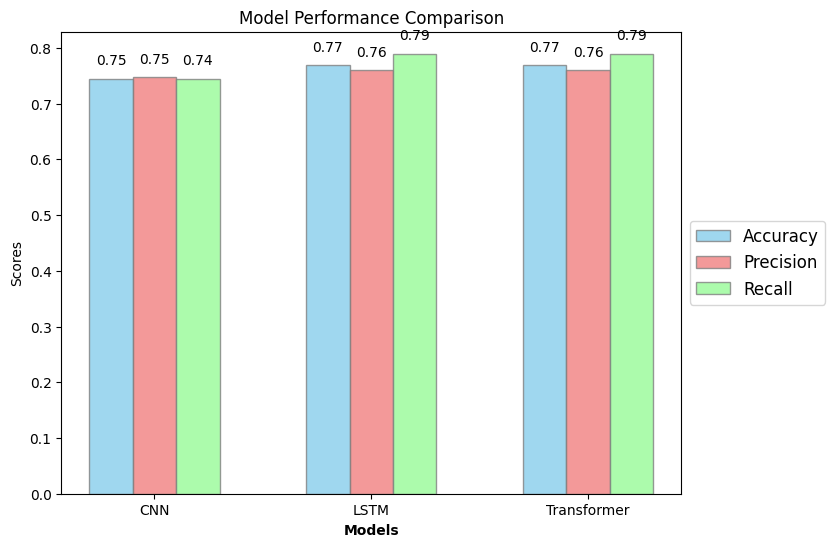

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score


#*********************Define function for drawing loss descending curve******************#
def draw_loss_curve(history,model_name):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title(model_name+' Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
#****************************************************************************************#

#**********************Define function for drawing confusion matrix***********************#   
def draw_conf_matrix(y_pre_classes,y_test,model_name):
    
    conf_matrix = confusion_matrix(y_test, y_pre_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(model_name+' Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()
#****************************************************************************************#

#*****************************Draw metrics bar plot***********************************#
def draw_bar(accuracy_l,precision_l,recall_l):
    model_names = ['CNN', 'LSTM', 'Transformer']
    bar_width = 0.2
    r1 = np.arange(len(model_names))  
    r2 = [x + bar_width for x in r1]  
    r3 = [x + bar_width for x in r2]  
    plt.figure(figsize=(8, 6))
    plt.bar(r1, accuracy_l, color='skyblue', width=bar_width, edgecolor='grey', label='Accuracy',alpha=0.8)
    plt.bar(r2, precision_l, color='lightcoral', width=bar_width, edgecolor='grey', label='Precision',alpha=0.8)
    plt.bar(r3, recall_l, color='palegreen', width=bar_width, edgecolor='grey', label='Recall',alpha=0.8)
    for i in range(len(r1)):
        plt.text(r1[i], accuracy_l[i] + 0.02, f'{accuracy_l[i]:.2f}', ha='center', va='bottom')
        plt.text(r2[i], precision_l[i] + 0.02, f'{precision_l[i]:.2f}', ha='center', va='bottom')
        plt.text(r3[i], recall_l[i] + 0.02, f'{recall_l[i]:.2f}', ha='center', va='bottom')
    plt.xlabel('Models', fontweight='bold')
    plt.xticks([r + bar_width for r in range(len(model_names))], model_names)  
    plt.title('Model Performance Comparison')
    plt.ylabel('Scores')
    plt.legend(fontsize=12, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
#***************************************************************************************#

#*******************************Function for evaluating**********************************#
def eva(model,history,X_test,y_test,name):
    # draw loss curve
    draw_loss_curve(history,name)
    # draw confusion matrix
    y_pre=model.predict(X_test)
    y_pre_classes = (y_pre> 0.5).astype("int32")
    draw_conf_matrix(y_pre_classes,y_test,name)
    accuracy_l.append(accuracy_score(y_test,y_pre_classes))
    precision_l.append(precision_score(y_test,y_pre_classes))
    recall_l.append(recall_score(y_test,y_pre_classes))
#****************************************************************************************#

if __name__=='__main__':
    accuracy_l=[]
    precision_l=[]
    recall_l=[]
    models=[[best_cnn_e,history1,'CNN'],[best_lstm_e,history2,'LSTM'],[best_lstm_e,history3,'Transformer']]
    for model,history,name in models:
        eva(model,history,X_test,y_test,name)
    draw_bar(accuracy_l,precision_l,recall_l)
    
        



    
    